<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/visual2textual/vs2txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as plt
import pandas as pd
import sklearn.metrics.pairwise as skpairwise
from matplotlib import pyplot as plt
from typing import List, Tuple, Dict

## Loading the dataset :

In [2]:
x_train: np.ndarray = None
x_test: np.ndarray = None
y_train: np.ndarray = None
y_test: np.ndarray = None
(x_train, y_train), (x_test, y_test) = (tf.keras.datasets.cifar100.load_data(label_mode="fine"))

169017344/169001437 [==============================] - 2s 0us/step


In [3]:
print(f"Train images shape:\t {x_train.shape}")
print(f"Train fine labels shape: {y_train.shape}")
print(f"Test images shape:\t {x_test.shape}")
print(f"Test fine labels shape:\t {y_test.shape}")

Train images shape:	 (50000, 32, 32, 3)
Train fine labels shape: (50000, 1)
Test images shape:	 (10000, 32, 32, 3)
Test fine labels shape:	 (10000, 1)


## The model 

In [59]:
class Mapping:
    def __init__(self, cnn, img_shape):
       self.cnn = cnn
       self.img_shape = img_shape
    
    def train(self, X_train, y_train, optimizer, loss, epochs=20, batch_size=32, last_layer_shape=300):
        #X_train = self.cnn.preprocess_input(X_train)
        base_model: tf.keras.Model = self.cnn
        base_model.trainable = False
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.Input(shape=(self.img_shape[0], self.img_shape[1], self.img_shape[2])))
        self.model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
        self.model.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
        self.model.add(base_model)
        self.model.add(tf.keras.layers.Dense(448, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.25))
        self.model.add(tf.keras.layers.Dense(384, activation='relu'))
        self.model.add(tf.keras.layers.Dropout(0.25))
        self.model.add(tf.keras.layers.Dense(last_layer_shape))
        self.model.summary()
        self.model.compile(optimizer=optimizer, loss=loss)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, mode="min",
                                                            restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, epochs=epochs, shuffle=True, 
                            batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])
    
    def plot_training_results(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()

    def test(self, X_test, y_test):
        model_eval: float = self.model.evaluate(X_test, y_test) 
        print(f"Model loss {model_eval}")
    
    def save_model(self, model_name):
        self.model.save(model_name+".model", save_format="h5")


## testing on cifar100 :
### Testing on different embedding :

In [5]:
import os
embs = sorted(os.listdir('/content/drive/MyDrive/data/embs'))
embs

['cifar100-roberta-base-0.csv',
 'cifar100-roberta-base-100.csv',
 'cifar100-roberta-base-200.csv',
 'cifar100-roberta-base-300.csv',
 'cifar100-roberta-base-400.csv',
 'cifar100-roberta-large-0.csv',
 'cifar100-roberta-large-100.csv',
 'cifar100-roberta-large-200.csv',
 'cifar100-roberta-large-300.csv',
 'cifar100-roberta-large-400.csv']

## Image embbedings :   
### Models :     
    1. VGG16
    2. ResNet
    3. MobileNet


In [58]:
from tensorflow.keras.applications import MobileNetV2, VGG19, ResNet50V2

cnn1 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling='max')
cnn2 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling='max')
cnn3 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling='max')

80150528/80134624 [==============================] - 1s 0us/step


## Preprocessing the text embeddings :

In [7]:
labels: List[str] = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
    'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
    'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can',
    'castle', 'caterpillar', 'cattle', 'chair',
    'chimpanzee', 'clock', 'cloud', 'cockroach',
    'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox',
    'girl', 'hamster', 'house', 'kangaroo',
    'computer_keyboard', 'lamp', 'lawn_mower',
    'leopard', 'lion', 'lizard', 'lobster', 'man',
    'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy',
    'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road',
    'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train',
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale',
    'willow_tree', 'wolf', 'woman', 'worm'
]

In [8]:
def txt_vec(emb_path):
    df = pd.read_csv(emb_path)
    df = df.drop(['embeddings'], axis = 1)
    label_vec = df.to_numpy()

    return label_vec

In [17]:
def compute_similarity(txt_vector):
    # calculate cosine similarity between each two labels
    similarity_matrix: np.ndarray = skpairwise.cosine_similarity(
        txt_vector, txt_vector)
    
    # get only lower triangle
    similarity_matrix: np.ndarray = np.tril(similarity_matrix, -1)

    # get indexes with cosine similarity greater than 0.65
    indexes: np.ndarray = np.argwhere(similarity_matrix > 0.6)

    # create dataframe for better printing
    labels_high_similarity: pd.DataFrame = pd.DataFrame(
        {'Label 1': [labels[i[0]] for i in indexes],
        'Label 2':  [labels[i[1]] for i in indexes],
        'cosine similarity': [similarity_matrix[i[0], i[1]] for i in indexes]
        }
    )
    print("\nFine labels with high cosine"
        "similarity and the cosine similarity value:\n"
        f"{labels_high_similarity}")

In [46]:
def compute_euclidean(txt_vector):
    # calculate cosine similarity between each two labels
    similarity_matrix: np.ndarray = skpairwise.euclidean_distances(
        txt_vector, txt_vector)
    
    # get only lower triangle
    similarity_matrix: np.ndarray = np.tril(similarity_matrix, -1)

    # get indexes with cosine similarity greater than 0.65
    indexes: np.ndarray = np.argwhere(similarity_matrix < 0.5)

    # create dataframe for better printing
    labels_high_similarity: pd.DataFrame = pd.DataFrame(
        {'Label 1': [labels[i[0]] for i in indexes],
        'Label 2':  [labels[i[1]] for i in indexes],
        'euclidean distance': [similarity_matrix[i[0], i[1]] for i in indexes]
        }
    )
    print("\nFine labels with high cosine"
        "similarity and the cosine similarity value:\n"
        f"{labels_high_similarity}")

##


In [10]:
path = '/content/drive/MyDrive/data/embs'

txt_vectors = dict()
for pth in embs:
    name = pth.split('.')[0]
    emb_path = os.path.join(path, pth)
    vecs = txt_vec(emb_path)
    txt_vectors[name] = vecs

In [12]:
embs

['cifar100-roberta-base-0.csv',
 'cifar100-roberta-base-100.csv',
 'cifar100-roberta-base-200.csv',
 'cifar100-roberta-base-300.csv',
 'cifar100-roberta-base-400.csv',
 'cifar100-roberta-large-0.csv',
 'cifar100-roberta-large-100.csv',
 'cifar100-roberta-large-200.csv',
 'cifar100-roberta-large-300.csv',
 'cifar100-roberta-large-400.csv']

In [11]:
print(txt_vectors['cifar100-roberta-base-0'].shape)
print(txt_vectors['cifar100-roberta-large-0'].shape)

(100, 768)
(100, 1024)


In [13]:
word2vec_emb = txt_vec('/content/drive/MyDrive/data/cifar100-wiki2vec-300.csv')

In [14]:
word2vec_emb.shape

(100, 300)

In [18]:
compute_similarity(word2vec_emb)


Fine labels with high cosinesimilarity and the cosine similarity value:
       Label 1        Label 2  cosine similarity
0      hamster            boy           0.773344
1         lion       flatfish           0.626982
2      lobster      crocodile           0.723904
3   motorcycle        bicycle           0.696072
4        skunk        raccoon           0.613739
5     squirrel        raccoon           0.618531
6        tiger        leopard           0.601433
7        trout  aquarium_fish           0.619525
8        whale       elephant           0.652803
9        whale          shark           0.621905
10       woman        hamster           0.700592
11       woman            man           0.685186


### Visualizing similarities between labels :    

In [19]:
for key, value in txt_vectors.items():
    print(key)
    compute_similarity(value)

cifar100-roberta-base-0

Fine labels with high cosinesimilarity and the cosine similarity value:
            Label 1        Label 2  cosine similarity
0     aquarium_fish          apple           0.999923
1              baby          apple           0.999975
2              baby  aquarium_fish           0.999922
3              bear          apple           0.999988
4              bear  aquarium_fish           0.999920
...             ...            ...                ...
4945           worm       wardrobe           0.999965
4946           worm          whale           0.999968
4947           worm    willow_tree           0.999926
4948           worm           wolf           0.999990
4949           worm          woman           0.999991

[4950 rows x 3 columns]
cifar100-roberta-base-100

Fine labels with high cosinesimilarity and the cosine similarity value:
            Label 1        Label 2  cosine similarity
0     aquarium_fish          apple           0.998810
1              baby    

## Preparing for training the neural network :

In [60]:
y_train_vecs: np.ndarray = np.asarray(
    [word2vec_emb[label] for label in y_train])
y_train_vecs: np.ndarray = y_train_vecs.reshape((50000, 300))
y_test_vecs: np.ndarray = np.asarray(
    [word2vec_emb[label] for label in y_test])
y_test_vecs: np.ndarray = y_test_vecs.reshape((10000, 300))

print(f"Train fine labels vectors shape: {y_train_vecs.shape}")
print(f"Test fine labels vectors shape: {y_test_vecs.shape}")

Train fine labels vectors shape: (50000, 300)
Test fine labels vectors shape: (10000, 300)


In [61]:
X_train: np.ndarray = tf.keras.applications.vgg19.preprocess_input(x_train)
X_test: np.ndarray = tf.keras.applications.vgg19.preprocess_input(x_test)

In [62]:
model = Mapping(cnn1, [32, 32, 3])

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CosineSimilarity(axis=1)
model.train(X_train, y_train_vecs, optimizer=optimizer, loss=loss)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_3 (Dense)             (None, 448)               229824    
                                                                 
 dropout_2 (Dropout)         (None, 448)               0         
                                                                 
 dense_4 (Dense)             (None, 384)               172416    
                                                      

In [64]:
model.test(X_test, y_test_vecs)

313/313 [==============================] - 137s 436ms/step - loss: -0.6614
Model loss -0.6614300608634949


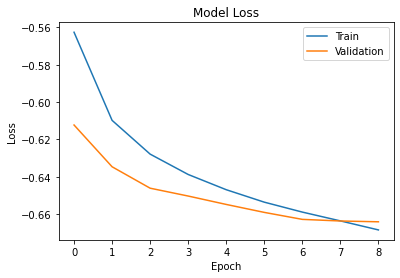

In [65]:
model.plot_training_results()

In [66]:
model.save_model("vggnet")

In [67]:
from tensorflow.keras.models import load_model

mob = load_model("/content/vggnet.model")

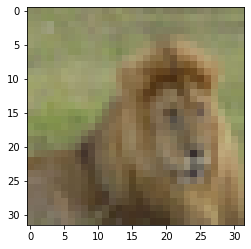

In [68]:
img: np.ndarray = x_test[15].copy()
plt.imshow(img)

In [69]:
prediction: np.ndarray = mob.predict(np.expand_dims(tf.keras.applications.vgg19.preprocess_input(img), axis=0))
prediction.shape

(1, 300)

In [70]:
import torch
import logging
from tqdm import tqdm

class EmbeddingsLoader:

    def __init__(self, filename : str):

        self.file = filename
        self.embeddings = {}

        self._load_file()

    def _load_file(self):
        try:
            with open(self.file, "r") as f:
                lines = f.readlines()
                
            for line in lines:
                data = line.split(",")
                self.embeddings[data[0]] = torch.FloatTensor(list(map(float, data[1:])))

        except IOError as e:
            raise IOError(f"No file {self.file}")

class SimilarityCompute(EmbeddingsLoader):

    def __init__(self, embeddings):
        super(SimilarityCompute, self).__init__(embeddings)


    def compute_sim(self):
        """ compute cosine similarity between all vectors """
        if len(self.embeddings) == 0:
            raise Exception("Tags not converted yet !")

        logging.info("Computing cosine similarity, this could take some time...")

        if self.cosine_sim_matrix is None:
            n_tokens = len(self.embeddings)
            self.cosine_sim_matrix = [[1 for j in range(n_tokens)] for i in range(n_tokens)]

        for j, vector in tqdm(enumerate(self.embeddings), total = len(self.embeddings)):

            for i, other_vector in enumerate(self.embeddings):

                if i == j:
                    continue

                cos = torch.nn.CosineSimilarity(dim=0)
                similarity = cos(vector[1], other_vector[1])

                self.cosine_sim_matrix[i][j] = similarity
                self.cosine_sim_matrix[j][i] = similarity

    def export_sim_matrix(self, filename):
        if self.cosine_sim_matrix == None:
            self.compute_sim()
        
        try:
            f = open(filename, "w")
        except OSError:
            raise OSError("Could not open file")

        with f:
            print("/", ",".join([tag[0] for tag in self.embeddings]), sep = ",", file = f)

            for j, tag_y in enumerate(self.embeddings):
                print(tag_y[0], ",".join( [str(round(float(self.cosine_sim_matrix[j][i]), 3)) for i in range(len(self.embeddings))]), sep = ",", file = f)

    def sim_between(self, token1, token2):
        index1, v1 = [(i, v[1]) for i, v in enumerate(self.embeddings) if v[0] == token1][0]
        index2, v2 = [(i, v[1]) for i, v in enumerate(self.embeddings) if v[0] == token2][0]

        if self.cosine_sim_matrix is None:
            n_tokens = len(self.embeddings)
            self.cosine_sim_matrix = [[1 for j in range(n_tokens)] for i in range(n_tokens)]

        if self.cosine_sim_matrix[index1][index2] == 0 or self.cosine_sim_matrix[index2][index1]:
            cos = torch.nn.CosineSimilarity(dim=0)
            similarity = cos(v1, v2)

            self.cosine_sim_matrix[index1][index2] = similarity
            self.cosine_sim_matrix[index2][index1] = similarity

        return self.cosine_sim_matrix[index1][index2]

class Solver(EmbeddingsLoader):

    def __init__(self, embeddings):
        super(Solver, self).__init__(embeddings)

    def get_nearest_embedding_of(self, embedding, nb = 100):

        if nb > len(self.embeddings):
            raise Exception("nb too high, not enough token")

        nearest = []
        for tag, e in self.embeddings.items():

            cos = torch.nn.CosineSimilarity(dim=0)
            similarity = cos(embedding, e)

            nearest.append((tag, similarity))
        
        nearest.sort(key = lambda tup : tup[1])
        return nearest[-1:-nb-1:-1]

In [71]:
solver = Solver("/content/drive/MyDrive/data/cifar100-wiki2vec-300.csv")
totest = torch.FloatTensor(prediction.reshape(-1))
print(solver.get_nearest_embedding_of(totest))

[('lion', tensor(0.9199)), ('leopard', tensor(0.7440)), ('elephant', tensor(0.7102)), ('tiger', tensor(0.6751)), ('wolf', tensor(0.6234)), ('bear', tensor(0.6037)), ('crocodile', tensor(0.5694)), ('porcupine', tensor(0.5667)), ('squirrel', tensor(0.5571)), ('dolphin', tensor(0.5553)), ('raccoon', tensor(0.5323)), ('camel', tensor(0.5316)), ('beaver', tensor(0.5226)), ('otter', tensor(0.5207)), ('rabbit', tensor(0.5134)), ('snake', tensor(0.5109)), ('chimpanzee', tensor(0.5041)), ('shark', tensor(0.4976)), ('shrew', tensor(0.4947)), ('turtle', tensor(0.4935)), ('seal', tensor(0.4917)), ('skunk', tensor(0.4704)), ('lizard', tensor(0.4543)), ('man', tensor(0.4532)), ('kangaroo', tensor(0.4491)), ('fox', tensor(0.4488)), ('whale', tensor(0.4484)), ('hamster', tensor(0.4386)), ('possum', tensor(0.4236)), ('crab', tensor(0.4229)), ('mouse', tensor(0.4179)), ('aquarium_fish', tensor(0.4118)), ('baby', tensor(0.4073)), ('boy', tensor(0.4035)), ('trout', tensor(0.4005)), ('mountain', tensor(0.3

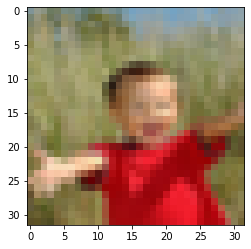

In [76]:
test_img : np.ndarray = x_test[37].copy()
plt.imshow(test_img)

In [77]:
pred2: np.ndarray = mob.predict(np.expand_dims(tf.keras.applications.vgg19.preprocess_input(test_img), axis=0))
solver = Solver("/content/drive/MyDrive/data/cifar100-wiki2vec-300.csv")
totest = torch.FloatTensor(pred2.reshape(-1))
print(solver.get_nearest_embedding_of(totest))

[('boy', tensor(0.7601)), ('man', tensor(0.7595)), ('girl', tensor(0.7482)), ('woman', tensor(0.7311)), ('baby', tensor(0.6994)), ('rabbit', tensor(0.5842)), ('wolf', tensor(0.5535)), ('elephant', tensor(0.5522)), ('sweet_pepper', tensor(0.5279)), ('fox', tensor(0.5248)), ('skunk', tensor(0.5244)), ('hamster', tensor(0.5132)), ('aquarium_fish', tensor(0.5099)), ('raccoon', tensor(0.5093)), ('squirrel', tensor(0.5059)), ('shark', tensor(0.5047)), ('snake', tensor(0.4983)), ('bottle', tensor(0.4893)), ('mouse', tensor(0.4867)), ('spider', tensor(0.4741)), ('turtle', tensor(0.4739)), ('bear', tensor(0.4687)), ('lion', tensor(0.4675)), ('chimpanzee', tensor(0.4665)), ('cockroach', tensor(0.4653)), ('crocodile', tensor(0.4644)), ('beaver', tensor(0.4611)), ('dolphin', tensor(0.4598)), ('lawn_mower', tensor(0.4573)), ('whale', tensor(0.4559)), ('camel', tensor(0.4530)), ('possum', tensor(0.4496)), ('palm_tree', tensor(0.4495)), ('crab', tensor(0.4421)), ('couch', tensor(0.4404)), ('tiger', t